# THỰC HÀNH SVM

## Bài toán: Phân loại văn bản sử dụng SVM

## Mục tiêu:
- Xây dựng được mô hình Naive Bayes sử dụng thư viện sklearn.
- Ứng dụng, hiểu cách áp dụng mô hình nb vào giải quyết bài toán thực tế (vd: phân loại văn
bản)
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình.

## Vấn đề: 
- Có một tập các văn bản dạng text không có nhãn, làm sao để biết văn bản này là thuộc
về thể loại nào, pháp luật, đời sống, văn học, thể thao ...

## Dữ liệu: 
- Tập các văn bản và nhãn tương ứng của từng văn bản trong một khoảng thời gian 
- Tập các nhãn gồm 10 nhãn văn bản: Giải trí, Khoa học - Công nghệ, Kinh tế, Pháp luật, Sức khỏe, Thể
thao, Thời sự, Tin khác, Độc giả, Đời sống - Xã hội 

Ví dụ văn bản nhãn thể thao: 

“Real Madrid đã dẫn trước trong cả trận đấu, nhưng họ vẫn phải chấp_nhận bị Dortmund cầm
hòa 2-2 ở Bernabeu. Real Madrid chấp_nhận đứng thứ_hai ở bảng F Champions League ...”

## Bài toán: Phân loại 
- Input: n vector mã hóa của các văn bản 
- Output: nhãn y là 1 trong 10 nhãn trên

## Bước 1 - Chuẩn bị các thư viện cần thiết

In [1]:
!pip install pyvi

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

%matplotlib inline

## Bước 2 - Load dữ liệu từ thư viện có sẵn

In [3]:
data_train = load_files(container_path="../data/news_1135/", encoding="utf-8")
print(data_train.filenames)
print()
print("Tổng số file: {}".format(len(data_train.filenames)))

['../data/news_1135/Tin khác\\0218e1df21ce358b9c6485176a48f1fcaeedef67.txt'
 '../data/news_1135/Khoa học - Công nghệ\\bf9889f5f2ffd6c92fa877d35ef0ef5f34f0666d.txt'
 '../data/news_1135/Tin khác\\d74aab054ffe9f8661df13bc52b438b48a63fe48.txt'
 ...
 '../data/news_1135/Thời sự\\a06c1ec4c146d3b4eb5070a1967e10e5e21bdc5b.txt'
 '../data/news_1135/Sức khỏe\\4187c4a1d528fd9ea4630d2709229df0b0d09c3d.txt'
 '../data/news_1135/Thể thao\\7adaf0c561796f2411340150f18417543ad4403c.txt']

Tổng số file: 1135


## Bước 3 - Tiền xử lý dữ liệu đưa dữ liệu dạng text về dạng ma trận

### Đưa dữ liệu số về dạng vector (thông qua bag-of-words và tf-idf)

In [4]:
# load dữ liệu các stopwords
with open("../data/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()

stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print(stopwords[:10])
# Transforming data
# Chuyển hoá dữ liệu text về dạng vector tfidf
#- loại bỏ từ dừng
#- sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)

model_rf_preprocess = Pipeline([
("vect", module_count_vector),
("tfidf", TfidfTransformer())
])

# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array
data_preprocessed = model_rf_preprocess.fit_transform(
    data_train.data, data_train.target
)

print("10 từ đầu tiên trong từ điển:")
i = 0
for k, v in module_count_vector.vocabulary_.items():
    i += 1
    print(i, ": ", (k, v))
    if i > 10:
        break

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
10 từ đầu tiên trong từ điển:
1 :  ('dân_trí', 6928)
2 :  ('sở', 17869)
3 :  ('gd', 7729)
4 :  ('đt', 23214)
5 :  ('tỉnh', 20851)
6 :  ('gia_lai', 7816)
7 :  ('văn_bản', 21779)
8 :  ('2258', 858)
9 :  ('sgdđt', 17039)
10 :  ('vp', 21572)
11 :  ('chấn_chỉnh', 4971)


In [5]:
# Dữ liệu khi được mã hóa thành dạng số
print(data_preprocessed.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00879757 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [6]:
# Gán nhãn từng chủ đề bài báo
print(data_train.target)

[7 1 7 ... 6 4 5]


In [7]:
# Nội dung của bài báo đầu tiên
print(data_train.data[0])

Dân_trí Sở GD & ĐT tỉnh Gia_Lai vừa ra văn_bản số 2258 / SGDĐT - VP , về việc chấn_chỉnh việc tiếp_thị sách và các vật_dụng khác trong các cơ_sở giáo_dục . Văn_bản chỉ_đạo , tuyệt_đối không cho phép các cá_nhân , tập_thể đến trường tiếp_thị , quảng_cáo mua_bán sách , dụng_cụ học_tập … cho giáo_viên và học_sinh trong nhà_trường . Các tổ_chức , cá_nhân trong ngành giáo_dục tuyệt_đối không được thực_hiện hoặc tham_gia giới_thiệu , quảng_bá , vận_động mua , phát_hành sách tham_khảo tới học_sinh hoặc phụ_huynh dưới hình_thức nào . Nhà_trường tuyệt_đối không được lưu_hành , sử_dụng sách có nội_dung không lành_mạnh , không phù_hợp với nội_dung chương_trình phổ_thông . Trường_hợp phát_hiện sách có sai_sót , các đơn_vị cần báo_cáo với cấp trên để có hướng xử_lý . Các sơ sở giáo_dục đề_cao cảnh_giác đối_với trường_hợp mạo_danh cán_bộ , chuyên_viên sở trong ngành đi giới_thiệu sách , đồ_dùng học_sinh ; công_khai phổ_biến các quy_định trên đến cán_bộ , giáo_viên , học_sinh để cùng phòng tránh và n

## Bước 4 - Chia dữ liệu thành 2 phần training và testing

In [8]:
from sklearn.model_selection import ShuffleSplit
test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    data_preprocessed, data_train.target, test_size=test_size
)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

Dữ liệu training =  (908, 24389) (908,)
Dữ liệu testing =  (227, 24389) (227,)


## Bước 5: Huấn luyện model SVM

In [9]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel="linear", C=1.0)
model.fit(X_train, y_train)
print("- model- train complete")

- Training ...
- Train size = (908, 24389)
- model- train complete


## Bước 6 - Test model SVM

In [10]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_pred = model.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))

- Testing ...
- Acc = 0.8898678414096917


### 6.1. Thực hiện các bước tương tự cho kernel SVM

#### 6.1.1. Huấn luyện kernel SVM

In [11]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model_rbf = svm.SVC(kernel="rbf", C=1.0)
model_rbf.fit(X_train, y_train)
print("- model- train complete")

- Training ...
- Train size = (908, 24389)
- model- train complete


#### 6.1.2. Test model

In [12]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_pred = model_rbf.predict(X_test)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))

- Testing ...
- Acc = 0.801762114537445


#### 6.1.3. Dự đoán nhãn văn bản

In [13]:
print(y_test[:5])
print(y_pred[:5])
for i in range(5):
    print(f"Văn bản thứ {i + 1}:")
    print(f"Nhãn đúng: {data_train.target_names[y_test[i]]}")
    print(f"Nhãn dự đoán: {data_train.target_names[y_pred[i]]}\n")


[2 6 2 3 0]
[2 6 2 1 0]
Văn bản thứ 1:
Nhãn đúng: Kinh tế
Nhãn dự đoán: Kinh tế

Văn bản thứ 2:
Nhãn đúng: Thời sự
Nhãn dự đoán: Thời sự

Văn bản thứ 3:
Nhãn đúng: Kinh tế
Nhãn dự đoán: Kinh tế

Văn bản thứ 4:
Nhãn đúng: Pháp luật
Nhãn dự đoán: Khoa học - Công nghệ

Văn bản thứ 5:
Nhãn đúng: Giải trí
Nhãn dự đoán: Giải trí



#### 6.1.4. Dự đoán văn bản bất kỳ

In [14]:
# Văn bản mới muốn dự đoán
new_doc = "Công phượng ghi bàn cho đội tuyển Việt Nam"

# Transform văn bản mới thành vector TF-IDF
new_doc_vector = model_rf_preprocess.transform([new_doc])

# Dự đoán bằng cả SVM RBF
pred_rbf = model_rbf.predict(new_doc_vector)[0]

print(f"\nVăn bản: \"{new_doc}\"")
print(f"Dự đoán RBF Kernel: {data_train.target_names[pred_rbf]}")


Văn bản: "Công phượng ghi bàn cho đội tuyển Việt Nam"
Dự đoán RBF Kernel: Khoa học - Công nghệ


## Bài tập bổ sung

### 1. Thử nghiệm các tham số

#### Vẽ Learning curve khảo sát Acc của SVM-linear với tham số C thay đổi

In [15]:
list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]
list_acc = []
title = "Learning Curves SVM, Linear kernel, change C"
# duyệt qua mảng các giá trị của tham số C
for i, C in enumerate(list_C):
    # Với từng giá trị C nhận được,
    # thực hiện build model và training cross-validate
    # vẽ kết quả tìm được lên đồ thị đường.
    model = svm.SVC(kernel="linear", C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    list_acc.append(accuracy_score(y_test, y_pred))

[Text(0, 0, '0.001'),
 Text(1, 0, '0.01'),
 Text(2, 0, '0.1'),
 Text(3, 0, '1'),
 Text(4, 0, '5.0'),
 Text(5, 0, '10.0'),
 Text(6, 0, '100')]

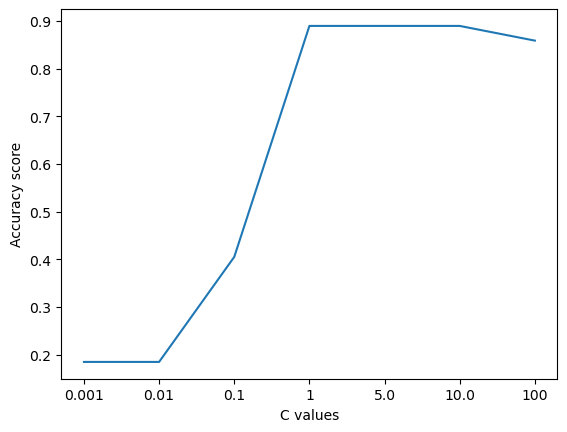

In [16]:
import seaborn as sns
fig = sns.lineplot(x=list(range(0, 7)), y=list_acc)
fig.set_xticks(range(0, 7))
fig.set_ylabel('Accuracy score')
fig.set_xlabel('C values')
fig.set_xticklabels([0.001, 0.01, 0.1, 1, 5.0, 10.0, 100])

#### Viết hàm sinh màu và hàm vẽ learning curve

In [19]:
# hàm sinh id màu
def get_cmap(n):
    return "C" + str(n)

# Hàm thực hiện training model, crossvalidate và vẽ lên đồ thị sử dụng matplotlib

def plot_learning_curve(
        estimator, title, label_curve, X, y, ylim=None, cv=None, 
        n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5), new_plot=False, 
        idx_color=0):
    # Khởi tạo bức ảnh mới với thư viện plot lib
    if new_plot:
    # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.grid()
    # chú thích nếu có
    if ylim is not None:
        plt.ylim(*ylim)
    # thực hiện training model, ghi nhận các giá trị trong quá trình training
    # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện 
    # training testing.

    # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để 
    # thực hiện 1 testing

    # train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực 
    # hiện test, tương tự 50 % ..
    # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring="accuracy")
    
    # Lấy trung bình cộng các giá trị output của các fold
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # random 1 màu để vẽ
    color = get_cmap(idx_color)
    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color=color)
    plt.plot(train_sizes, test_scores_mean, "o-", color=color, label=label_curve)
    plt.legend(loc="upper right")

    return plt

#### Vẽ biểu đồ thể hiện mối quan hệ giữa số lượng mẫu, tham số C và accuracy

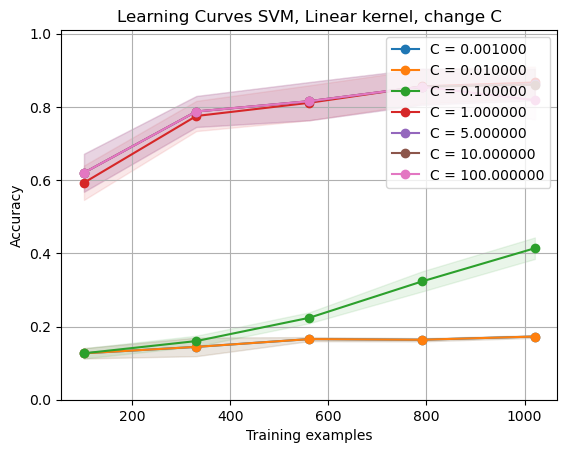

In [20]:
list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]
# model title
6
title = "Learning Curves SVM, Linear kernel, change C"
# duyệt qua mảng các giá trị của tham số C
for i, C in enumerate(list_C):
    # Với từng giá trị C nhận được,
    # thực hiện build model và training cross-validate
    # vẽ kết quả tìm được lên đồ thị đường.
    text_clf = Pipeline([
    ("clf", svm.SVC(kernel="linear", C=C)), # mô hình svm với tham số C
    ])
    plt = plot_learning_curve(
        text_clf, title, "C = %f" % (C), data_preprocessed, 
        data_train.target, (0.0, 1.01), cv=10, n_jobs=-1, 
        idx_color=i, new_plot=i == 0
    )
# lưu hình ảnh ra file
# plt.savefig('images/changeC.png', bbox_inches='tight')
plt.show()

### 2. Sử dụng GridSearchCV để tìm bộ tham số tốt nhất

In [21]:
params_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100], 
    "gamma": [0.0001, 0.001, 0.01, 0.1], 
    "kernel": ["linear", "rbf", "poly"]
}

model = svm.SVC()
# Create the GridSearchCV object
best_model = GridSearchCV(model, params_grid, cv=4, n_jobs=-1, scoring="accuracy")
# Fit the data with the best possible parameters
best_model.fit(X_train, y_train)
# Print the best estimator with it's parameters
print(best_model.best_params_)
print(best_model.best_estimator_)
# Test best_model
print("Testing")
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
SVC(C=1, gamma=0.0001, kernel='linear')
Testing
0.8898678414096917


### 3. Phân loại số viết tay

#### 3.1. Tìm hiểu dữ liệu

Dữ liệu training =  (1437, 64) (1437,)
Dữ liệu testing =  (360, 64) (360,)


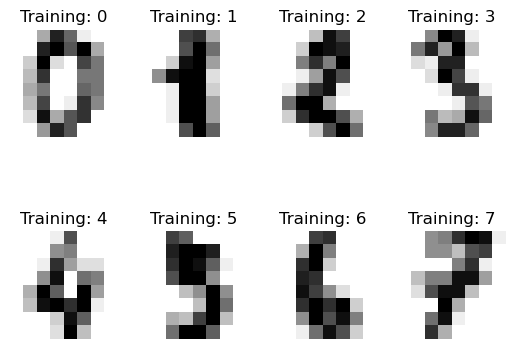

In [23]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
# The digits dataset
digits = datasets.load_digits()
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset. If we were working from image files, we could load them using
# matplotlib.pyplot.imread. Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))

for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis("off")
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title("Training: %i" % label)
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples,-1))
target = digits.target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size)
print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

#### 3.2. Phân loại số viết tay sử dụng SVM

In [25]:
params_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100], 
    "gamma": [0.0001, 0.001, 0.01, 0.1], 
    "kernel": ["linear", "rbf", "poly"]
}

model_digits = svm.SVC()
# Create the GridSearchCV object
best_model_digits = GridSearchCV(
    model_digits, params_grid, cv=5, n_jobs=-1, scoring="accuracy"
)

# Fit the data with the best possible parameters
best_model_digits.fit(X_train, y_train)
# Print the best estimator with it's parameters
print(best_model_digits.best_params_)
print(best_model_digits.best_estimator_)
# Test best_model
print("Testing")
y_pred = best_model_digits.predict(X_test)
print(accuracy_score(y_test, y_pred))

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001)
Testing
0.9972222222222222
